In [ ]:
import json
import re
import matplotlib.pyplot as plt

from collections import Counter
from underthesea import word_tokenize

In [ ]:
!pip install underthesea

**1. DATA INTEGRATION**

In [ ]:
# -- VNEXPRESS --
with open('vnexpress.json', 'r', encoding='utf-8') as f:
    data_vnex = json.load(f)

# Kiểm tra số lượng bài báo
print('Số lượng bài báo: ',len(data_vnex))

# Kiểm tra cấu trúc mỗi bài
print('Cấu trúc của mỗi bài: ', data_vnex[0].keys())

Số lượng bài báo:  5428
Cấu trúc của mỗi bài:  dict_keys(['url', 'title', 'author', 'publish_date', 'content', 'status', 'category', 'source'])


In [ ]:
# -- VIETNAMNET --
with open('vietnamnet.json', 'r', encoding='utf-8') as f:
    data_vnnet = json.load(f)

# Kiểm tra số lượng bài báo
print('Số lượng bài báo: ',len(data_vnnet))

# Kiểm tra cấu trúc mỗi bài
print('Cấu trúc của mỗi bài: ', data_vnnet[0].keys())

Số lượng bài báo:  4646
Cấu trúc của mỗi bài:  dict_keys(['url', 'title', 'category', 'content', 'crawl_time', 'publish_time'])


In [ ]:
for a in data_vnnet:
    if "publish_time" in a:
        a["publish_date"] = a.pop("publish_time")

In [ ]:
# -- DÂN TRÍ --
with open('dantri.json', 'r', encoding='utf-8') as f:
    data_dt = json.load(f)

# Kiểm tra số lượng bài báo
print('Số lượng bài báo: ',len(data_dt))

# Kiểm tra cấu trúc mỗi bài
print('Cấu trúc của mỗi bài: ', data_dt[0].keys())

Số lượng bài báo:  2931
Cấu trúc của mỗi bài:  dict_keys(['url', 'title', 'author', 'publish_date', 'content', 'category', 'source', 'status'])


In [ ]:
## -- DATA INTEGRATION VÀ LOẠI BỎ CÁC CỘT KHÔNG CẦN THIẾT --
# Loại bỏ các cột không dùng đến
keep_keys = {'url', 'title','content', 'category', 'publish_date'}
merged_data = []

merged_data = [
    {k: a.get(k) for k in keep_keys}
    for a in (data_vnex + data_vnnet + data_dt)
]
print(merged_data[0].keys())
print(len(merged_data))

dict_keys(['category', 'url', 'title', 'content', 'publish_date'])
13005


**2. DATA CLEANING**

In [ ]:
# Kiểm tra các bài báo trùng lặp bằng url
urls = [a.get("url") for a in merged_data if a.get("url")]
url_counter = Counter(urls)

dup_urls = {u: c for u, c in url_counter.items() if c > 1}

print("Số URL trùng:", len(dup_urls))

Số URL trùng: 0


In [ ]:
# Kiểm tra giá trị null
keys_required = ['url', 'title', 'category', 'publish_date']

clean_data = []

for a in merged_data:
    # kiểm tra các key bắt buộc (trừ content)
    valid = True
    for k in keys_required:
        if k not in a or a[k] is None or str(a[k]).strip() == "":
            valid = False
            break

    # kiểm tra riêng content
    content = a.get("content")
    if content is None or len(str(content).strip()) <= 20:
        valid = False

    if valid:
        clean_data.append(a)

print(len(clean_data))

11226


In [ ]:
# Chuẩn hóa định dạng cho publish_date
def normalize_date(date_str):
    if not date_str:
        return None
    # dd/mm/yyyy
    match = re.search(r'\d{1,2}/\d{1,2}/\d{4}', date_str)
    if match:
        return match.group()

    return None
for a in clean_data:
    a["publish_date"] = normalize_date(a.get("publish_date"))

**3. TEXT NORMALIZATION**

In [ ]:
# Gộp title và content
for a in clean_data:
    a["text"] = a["title"] + "." + a["content"]

In [ ]:
def basic_clean(text):
    text = text.lower()                 # 1. chữ thường
    text = re.sub(r'\n+', ' ', text)    # 2. bỏ xuống dòng
    text = re.sub(r'\s+', ' ', text)    # 3. gộp khoảng trắng
    return text.strip()

for a in clean_data:
    a["text"] = basic_clean(a["text"])

In [ ]:
for a in clean_data:
    a["text_embed"] = a["text"]

In [ ]:
# load stopwords
stopwords = set(
    open("vietnamese-stopwords-dash.txt", encoding="utf-8")
    .read()
    .splitlines()
)

def preprocess_tfidf(text):
    text = re.sub(r'[^a-zA-ZÀ-ỹ\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    tokens = word_tokenize(text, format="text").split()
    tokens = [w for w in tokens if w not in stopwords]

    return " ".join(tokens)

# áp dụng
for a in clean_data:
    a["text_tfidf"] = preprocess_tfidf(a["text"])

In [ ]:
print(clean_data[0].keys())
print(clean_data[0])

dict_keys(['category', 'url', 'title', 'content', 'publish_date', 'text', 'text_embed', 'text_tfidf'])
{'category': 'Chính trị', 'url': 'https://vnexpress.net/thu-tuong-chuc-mung-u22-viet-nam-gianh-huy-chuong-vang-sea-games-33-4995605.html', 'title': 'Thủ tướng chúc mừng U22 Việt Nam giành Huy chương Vàng SEA Games 33', 'content': 'Trong thư, Thủ tướng thay mặt Chính phủ và người hâm mộ bóng đá cả nước chúc mừng ban huấn luyện và các vận động viên đã thi đấu kiên cường, nỗ lực hết mình trong suốt hành trình tại SEA Games 33, qua đó mang về thành tích cao cho thể thao Việt Nam.\nLãnh đạo Chính phủ nhấn mạnh năm 2025 đánh dấu nhiều kết quả nổi bật của bóng đá Việt Nam, với chức vô địch Đông Nam Á của đội tuyển nam quốc gia; lần thứ 3 liên tiếp vô địch U23 Đông Nam Á; đội tuyển bóng đá nữ quốc gia giành Huy chương Bạc SEA Games 33; cùng Huy chương Vàng của đội tuyển nữ futsal quốc gia và đội tuyển bóng đá nam U22 tại kỳ đại hội lần này.\n"Từng trận đấu đều thể hiện bản lĩnh, nhiệt huyết, 

In [ ]:
categories = set(item["category"] for item in clean_data)

#for cat in categories:
    #print(cat)
category_map = {
    "Politics": "Chính trị",
    "Business": "Kinh doanh",
    "Sports": "Thể thao",
    "Health": "Sức khỏe",
    "Education": "Giáo dục",
    "Entertainment": "Giải trí"
}
for item in clean_data:
    if "category" in item:
        item["category"] = category_map.get(item["category"], item["category"])

[373, 1142, 836, 482, 512, 1497, 416, 859, 406, 354, 604, 546, 766, 490, 1145, 574, 475, 599, 414, 139, 333, 969, 426, 535, 852, 1002, 676, 922, 583, 1156, 865, 1381, 638, 786, 1176, 307, 1159, 441, 1005, 670, 690, 623, 504, 587, 673, 540, 673, 1191, 700, 590, 762, 592, 628, 549, 662, 474, 1011, 630, 582, 655, 631, 736, 874, 405, 477, 485, 566, 460, 297, 510, 485, 394, 732, 485, 635, 945, 822, 842, 680, 563, 588, 681, 939, 445, 891, 317, 442, 577, 455, 475, 906, 442, 388, 340, 1064, 1275, 462, 820, 1396, 752, 444, 596, 1055, 866, 928, 495, 1037, 928, 599, 824, 824, 484, 625, 942, 750, 973, 635, 1034, 1054, 521, 604, 508, 547, 755, 997, 2375, 518, 219, 242, 792, 406, 442, 405, 347, 419, 513, 258, 679, 625, 660, 419, 840, 596, 762, 275, 406, 632, 317, 779, 301, 464, 921, 901, 337, 1379, 338, 303, 283, 600, 1091, 227, 665, 1143, 340, 671, 548, 511, 816, 614, 1002, 731, 352, 354, 773, 1222, 1005, 378, 993, 478, 1256, 333, 924, 518, 1409, 802, 375, 396, 660, 705, 853, 960, 770, 543, 582, 69

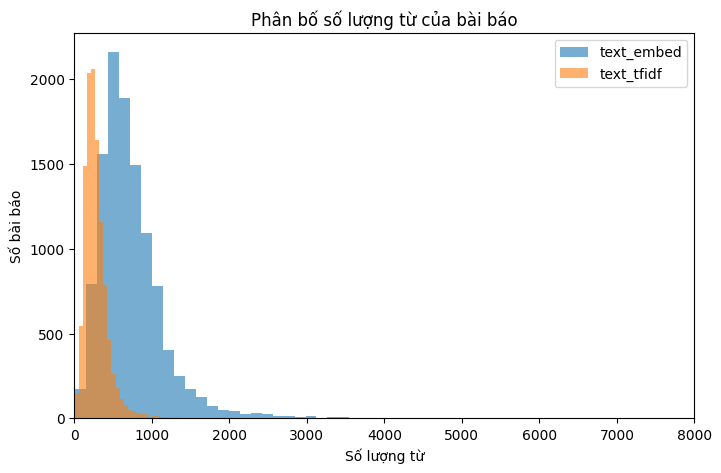

In [ ]:
len_embed = [len(item["text_embed"].split()) for item in clean_data]
len_tfidf = [len(item["text_tfidf"].split()) for item in clean_data]

print(len_embed)
print(len_tfidf)

plt.figure(figsize=(8,5))
plt.hist(len_embed, bins=500, alpha=0.6, label="text_embed")
plt.hist(len_tfidf, bins=500, alpha=0.6, label="text_tfidf")
plt.xlim(0, 8000)

plt.xlabel("Số lượng từ")
plt.ylabel("Số bài báo")
plt.title("Phân bố số lượng từ của bài báo")
plt.legend()
plt.show()

In [ ]:
import json

with open("data.json", "w", encoding="utf-8") as f:
    json.dump(clean_data, f, ensure_ascii=False, indent=2)